# ДЗ 04. Сверточные нейронные сети. Введение в искусственные нейронные сети

<ol>
    <li>Попробовать улучшить точность распознования образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложить анализ с описанием того, что улучшает работу нейронной сети и что ухудшает.
    </li>
    <li>Описать также в анализе какие необоходимо внести изменения  в получившуюся у вас нейронную сеть если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.
    </li>
</ol>

In [153]:
from numpy import asarray
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalMaxPooling2D

## Задание 1

Попробовать улучшить точность распознования образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложить анализ с описанием того, что улучшает работу нейронной сети и что ухудшает.

In [154]:
from keras.datasets import mnist
from keras.utils import np_utils

In [155]:
from __future__ import print_function
import keras # расскоментируйте эту строку, чтобы начать обучение
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [156]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [157]:
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [158]:
# Нормализация
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [173]:
results = []
counter = 1
# установка параметров нейросети
batch_sizes = [32,256]
num_classes = 10
epochs = [1,3]
data_augmentations = [True,False]
num_predictions = 20
optimizers = ['Adagrad','Adamax','Nadam','Ftrl', 'SGD','RMSprop','Adam','Adadelta']
learning_rates = [0.0001, 0.001]


for optimizer in optimizers:
    for batch in batch_sizes:
        for data_augmentation in data_augmentations:
            for LR in learning_rates:
                for epoch in epochs:

                    # конфигурирование слоев нейросети
                    model = Sequential()

                    # слои нейросети отвественные за свертку и max-pooling
                    model.add(Conv2D(32, (3, 3), padding='same',
                                     input_shape=x_train.shape[1:]))
                    model.add(Activation('relu'))
                    model.add(Conv2D(32, (3, 3)))
                    model.add(Activation('relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    model.add(Dropout(0.25))

                    model.add(Conv2D(64, (3, 3), padding='same'))
                    model.add(Activation('relu'))
                    model.add(Conv2D(64, (3, 3)))
                    model.add(Activation('relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    model.add(Dropout(0.25))

                    # полносвязные слои нейронной сети
                    model.add(Flatten())
                    model.add(Dense(512))
                    model.add(Activation('relu'))
                    model.add(Dropout(0.5))
                    model.add(Dense(num_classes))
                    model.add(Activation('softmax'))

                    # инициализация optimizer
                    if optimizer == 'RMSprop':
                        opt = keras.optimizers.RMSprop(lr=LR, decay=1e-6)
                    elif optimizer == 'SGD':
                        opt = keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
                    elif optimizer == 'Adam':
                        opt = keras.optimizers.Adam(learning_rate=LR)
                    elif optimizer == 'Adadelta':
                        opt = keras.optimizers.Adadelta(learning_rate=LR, rho=0.95, epsilon=1e-07)
                    elif optimizer == 'Adagrad':
                        opt = keras.optimizers.Adagrad(learning_rate=LR,initial_accumulator_value=0.1,epsilon=1e-07)
                    elif optimizer == 'Adamax':
                        opt = keras.optimizers.Adamax(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
                    elif optimizer == 'Nadam':
                        opt = keras.optimizers.Nadam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
                    elif optimizer == 'Ftrl':
                        opt = keras.optimizers.Ftrl(learning_rate=LR, learning_rate_power=-0.5,initial_accumulator_value=0.1,
                                                       l1_regularization_strength=0.0,l2_regularization_strength=0.0)

                    # компиляция модели
                    model.compile(loss='categorical_crossentropy',
                                  optimizer=opt,
                                  metrics=['accuracy'])

                    if not data_augmentation:
                        print('Не используется data augmentation')
                        model.fit(x_train, y_train,
                                  batch_size=batch,
                                  epochs=epoch,
                                  validation_data=(x_test, y_test),
                                  shuffle=True)
                    else:
                        print('Использование data augmentation в реальном времени')
                        # Препроцессинг и data augmentation в реальном времени:
                        datagen = ImageDataGenerator(
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False, 
                            zca_epsilon=1e-06, 
                            rotation_range=0, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0., 
                            zoom_range=0., 
                            channel_shift_range=0.,
                            fill_mode='nearest',
                            cval=0.,
                            horizontal_flip=True,
                            vertical_flip=False,
                            rescale=None,
                            preprocessing_function=None,
                            data_format=None,
                            validation_split=0.0)

                        # запуск data augmentation через fit
                        #datagen.fit(x_train)

                        # запуск data augmentation через fit_generator
                        model.fit_generator(datagen.flow(x_train, y_train,
                                                         batch_size=batch),
                                            epochs=epoch,
                                            validation_data=(x_test, y_test),
                                            workers=4, verbose=0)

                        # проверка работы обученной модели
                        test_loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
                        item = {'counter':counter, 'optimizer':optimizer, 'data_augmentation':data_augmentation,'test_loss':test_loss, 'accuracy':accuracy, 'epochs':epoch,
                                'batch_size':batch, 'LearnRate':LR, }

                        print(item)
                        results.append(item)
                        counter +=1

Использование data augmentation в реальном времени
313/313 [==============================] - 6s 18ms/step - loss: 2.3001 - accuracy: 0.1184
{'counter': 1, 'optimizer': 'Adagrad', 'data_augmentation': True, 'test_loss': 2.3000569343566895, 'accuracy': 0.11840000003576279, 'epochs': 1, 'batch_size': 32, 'LearnRate': 0.0001}
Использование data augmentation в реальном времени
313/313 [==============================] - 6s 18ms/step - loss: 2.2874 - accuracy: 0.1190
{'counter': 2, 'optimizer': 'Adagrad', 'data_augmentation': True, 'test_loss': 2.2874231338500977, 'accuracy': 0.11900000274181366, 'epochs': 3, 'batch_size': 32, 'LearnRate': 0.0001}
Использование data augmentation в реальном времени
313/313 [==============================] - 6s 19ms/step - loss: 2.2352 - accuracy: 0.1984
{'counter': 3, 'optimizer': 'Adagrad', 'data_augmentation': True, 'test_loss': 2.2351694107055664, 'accuracy': 0.19840000569820404, 'epochs': 1, 'batch_size': 32, 'LearnRate': 0.001}
Использование data augment

313/313 [==============================] - 5s 17ms/step - loss: 1.7636 - accuracy: 0.3794
{'counter': 14, 'optimizer': 'Adamax', 'data_augmentation': True, 'test_loss': 1.7636364698410034, 'accuracy': 0.37940001487731934, 'epochs': 3, 'batch_size': 256, 'LearnRate': 0.0001}
Использование data augmentation в реальном времени
313/313 [==============================] - 5s 17ms/step - loss: 1.5612 - accuracy: 0.4311
{'counter': 15, 'optimizer': 'Adamax', 'data_augmentation': True, 'test_loss': 1.5612177848815918, 'accuracy': 0.4311000108718872, 'epochs': 1, 'batch_size': 256, 'LearnRate': 0.001}
Использование data augmentation в реальном времени
313/313 [==============================] - 6s 18ms/step - loss: 1.2945 - accuracy: 0.5355
{'counter': 16, 'optimizer': 'Adamax', 'data_augmentation': True, 'test_loss': 1.2944732904434204, 'accuracy': 0.5354999899864197, 'epochs': 3, 'batch_size': 256, 'LearnRate': 0.001}
Не используется data augmentation
196/196 [==============================] - 

Использование data augmentation в реальном времени
313/313 [==============================] - 6s 19ms/step - loss: 2.3026 - accuracy: 0.1000
{'counter': 28, 'optimizer': 'Ftrl', 'data_augmentation': True, 'test_loss': 2.302586793899536, 'accuracy': 0.10000000149011612, 'epochs': 3, 'batch_size': 32, 'LearnRate': 0.001}
Не используется data augmentation
1563/1563 [==============================] - 174s 112ms/step - loss: 2.3026 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Не используется data augmentation
Epoch 1/3
1563/1563 [==============================] - 170s 109ms/step - loss: 2.3026 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/3
1563/1563 [==============================] - 169s 108ms/step - loss: 2.3026 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/3
1563/1563 [==============================] - 171s 109ms/step - loss: 2.3026 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Не используется data augmentation

Не используется data augmentation
Epoch 1/3
196/196 [==============================] - 117s 595ms/step - loss: 2.3112 - accuracy: 0.1013 - val_loss: 2.3010 - val_accuracy: 0.1173
Epoch 2/3
196/196 [==============================] - 117s 598ms/step - loss: 2.3055 - accuracy: 0.1048 - val_loss: 2.2992 - val_accuracy: 0.1181
Epoch 3/3
196/196 [==============================] - 118s 602ms/step - loss: 2.3023 - accuracy: 0.1065 - val_loss: 2.2980 - val_accuracy: 0.1178
Не используется data augmentation
196/196 [==============================] - 118s 604ms/step - loss: 2.2970 - accuracy: 0.1118 - val_loss: 2.2843 - val_accuracy: 0.1370
Не используется data augmentation
Epoch 1/3
196/196 [==============================] - 119s 606ms/step - loss: 2.3003 - accuracy: 0.1090 - val_loss: 2.2906 - val_accuracy: 0.1337
Epoch 2/3
196/196 [==============================] - 118s 603ms/step - loss: 2.2750 - accuracy: 0.1349 - val_loss: 2.2461 - val_accuracy: 0.1924
Epoch 3/3
196/196 [===================

Не используется data augmentation
1563/1563 [==============================] - 177s 113ms/step - loss: 1.5167 - accuracy: 0.4457 - val_loss: 1.1093 - val_accuracy: 0.6068
Не используется data augmentation
Epoch 1/3
1563/1563 [==============================] - 178s 114ms/step - loss: 1.5338 - accuracy: 0.4398 - val_loss: 1.1825 - val_accuracy: 0.5846
Epoch 2/3
1563/1563 [==============================] - 174s 111ms/step - loss: 1.1407 - accuracy: 0.5945 - val_loss: 0.9925 - val_accuracy: 0.6513
Epoch 3/3
1563/1563 [==============================] - 175s 112ms/step - loss: 0.9928 - accuracy: 0.6477 - val_loss: 0.9183 - val_accuracy: 0.6780
Использование data augmentation в реальном времени
313/313 [==============================] - 6s 19ms/step - loss: 1.7595 - accuracy: 0.3842
{'counter': 53, 'optimizer': 'Adam', 'data_augmentation': True, 'test_loss': 1.7595291137695312, 'accuracy': 0.38420000672340393, 'epochs': 1, 'batch_size': 256, 'LearnRate': 0.0001}
Использование data augmentatio

196/196 [==============================] - 163s 832ms/step - loss: 2.3072 - accuracy: 0.1072 - val_loss: 2.2996 - val_accuracy: 0.1128
Epoch 3/3
196/196 [==============================] - 156s 794ms/step - loss: 2.3047 - accuracy: 0.1096 - val_loss: 2.2984 - val_accuracy: 0.1186


In [174]:
# создаём датафрейм из результатов
import pandas as pd
results_df = pd.DataFrame(results)
results_df.drop(columns="counter", inplace = True)
results_df.sort_values('accuracy', ascending=False, inplace=True)

In [175]:
results_df.to_csv('network_results.csv', sep=';')
results_df.head()

,optimizer,data_augmentation,test_loss,accuracy,epochs,batch_size,LearnRate
19,Nadam,True,0.833661,0.7055,3,32,0.001
43,RMSprop,True,1.038111,0.6537,3,32,0.001
51,Adam,True,0.983569,0.6498,3,32,0.001
11,Adamax,True,1.111882,0.6015,3,32,0.001
55,Adam,True,1.108363,0.6006,3,256,0.001


In [176]:
optimizer_v = results_df['optimizer']
data_augmentation_v = results_df['data_augmentation']
only_numbers = ['accuracy', 'epochs', 'batch_size', 'LearnRate']

In [189]:
import numpy as np
# посмотрим, как влияет алгоритм оптимизации на результаты модели:
table = pd.pivot_table(results_df, index=['optimizer'], aggfunc=np.mean)
table.sort_values('accuracy',ascending=False, inplace=True)
table.head()

,LearnRate,accuracy,batch_size,data_augmentation,epochs,test_loss
optimizer,,,,,,
Nadam,0.00055,0.523413,144,True,2,1.324594
Adam,0.00055,0.514888,144,True,2,1.351777
RMSprop,0.00055,0.478788,144,True,2,1.465889
Adamax,0.00055,0.435387,144,True,2,1.574567
SGD,0.00055,0.231362,144,True,2,2.071583


На имеющихся данных наилучшим алгоритмом оптимизации оказалася "Nadam" и "Adam"

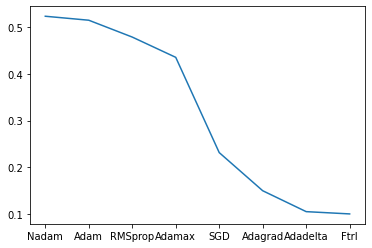

In [190]:
# влияние оптимизатора на точность:

import matplotlib.pyplot as plt

plt.plot(table.index,table['accuracy'])

#### посмотрим на корреляционную матрицу:

/Users/artem/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


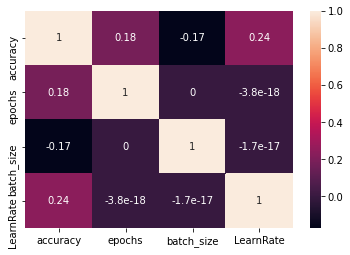

In [195]:
from sklearn import preprocessing
import seaborn as sn

df = pd.DataFrame(results_df, columns = only_numbers)

# делаем нормализацию
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)



# построим тепловую карту
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### Итоги и выводы

На рассмотренном датасате:

* удалось получить максимальную точность 0.7 (намного лучше по сравнению с базовым примером 0.42)
* лучшим оптимайзером оказалася "Nadam" & "Adam"
* на точность влияют все параметры нейронной сети
* увеличение кол-ва эпох увеличивает точность
* увеличение батча уменьшает точность
* увеличение лёрнинг-рейта увеличивает точность

## Задание 2

Описать также в анализе какие необоходимо внести изменения в получившуюся у вас нейронную сеть если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.

* Нужно изменять кол-во нейронов во входном слое в соответствии с разрешением картинок каждого датасата
* Нужно изменять кол-во нейронов в выходном слое в соответствии с кол-вом классов в каждом датасете. Если кол-во классов 100 (как в CIFAR100), то и нейронов в выходном слое должно быть тоже 100
* в IMAGENET высокое разрешение картинок можно уменьшить до какой-то разумного размера, при котором качество модели не пострадает, но удастся сократить кол-во нейронов во входном слое, это также потребуется, если картинки имеют разное разрешение - в этом случае изображения нужно привести к одному размеру